# Generate Adversarial Samples for Deep Learning Models with the Adversarial Robustness Toolbox (ART)

This notebook shows how to use adversarial attack techniques from the [Adversarial Robustness Toolbox (ART)](https://developer.ibm.com/code/open/projects/adversarial-robustness-toolbox/) on Deep Learning models trained with [Fabric for Deep Learning (FfDL)](https://github.com/IBM/ffdl/). The ART library supports crafting and analyzing various attack and defense methods for deep learning models. 

In this notebook, you will learn how to incorporate one of the attack methods supported by ART, the *Fast Gradient Method (FGM)*, into your training pipeline to generate adversarial samples to evaluate the robustness of the trained model. The model is a *Convolutional Neural Network (CNN)* trained on the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset using the [Keras](https://keras.io/) deep learning framework with a [TensorFlow](https://www.tensorflow.org/) backend.

The Github repository for the ART library can be found here: https://github.com/IBM/adversarial-robustness-toolbox

This notebook uses Python 3.


## Contents

1.	[Set up the environment](#setup)
2.	[Create a Keras model](#model)
3.  [Train the model](#train)
4.	[Generate adversarial samples for a robustness check](#art)
5.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

It is recommended that you run this notebook inside a Python 3 virtual environment. Make sure you have all required libraries installed.

To store model and training data, this notebook requires access to a Cloud Object Storage (COS) instance. [BlueMix Cloud Object Storage](https://console.bluemix.net/catalog/services/cloud-object-storage) offers a free *lite plan*. Follow [these instructions](https://dataplatform.ibm.com/docs/content/analyze-data/ml_dlaas_object_store.html) to create your COS instance and generate [service credentials](https://console.bluemix.net/docs/services/cloud-object-storage/iam/service-credentials.html#service-credentials) with [HMAC keys](https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials).


**Enter your cluster and object storage information:**

In [1]:
import os

env = dict(os.environ)

user_data = {
    "public_ip"                  : env.get("PUBLIC_IP"),             # Public IP of your Kubernetes cluster with FfDL deployed on it 
    "kubeconfig_file"            : env.get("KUBECONFIG"),            # Path pointing to your Kubernetes cluster configuration file 
    "cos_hmac_access_key_id"     : env.get("AWS_ACCESS_KEY_ID"),     # Cloud Object Storage (AWS) Access Key ID 
    "cos_hmac_secret_access_key" : env.get("AWS_SECRET_ACCESS_KEY"), # Cloud Object Storage (AWS) Secret Access Key 
    "cos_service_endpoint"       : env.get("AWS_ENDPOINT_URL"),      # Cloud Object Storage endpoint, i.e. 'https://s3-api.us-geo.objectstorage.softlayer.net' 
    "cos_region_name"            : env.get("AWS_DEFAULT_REGION"),    # Cloud Object Storage default region, i.e. 'us-east-1' 
    "ffdl_dir"                   : env.get("FFDL_DIR", os.getcwd().replace("/demos/fashion-mnist-adversarial", ""))
}

In [2]:
unset_vars = [key for (key, value) in user_data.items() if not value]

for var in unset_vars:
    print("Dictionary 'user_data' is missing '%s'" % var)
    
assert not unset_vars, "Enter 'user_data' to run this notebook!"

### 1.1. Verify or Install Required Python Libraries

In [3]:
import sys

def is_venv():
    return (hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix))

try:
    import keras, tensorflow, requests, wget, boto3, art
    print("All required libraries are installed.")
    !cat requirements.txt
except ModuleNotFoundError:
    if is_venv:
        print("Installing required libraries into virtual environment.")
        !python -m pip install -r requirements.txt
    else:
        print("Please install the required libraries.")
        !cat requirements.txt

Using TensorFlow backend.


All required libraries are installed.
keras>=2.1.6
tensorflow>=1.8
ipython>=5.0.0
jupyter>=1.0.0
requests>=2.12.0,<=2.18.4
wget
boto3
git+git://github.com/IBM/adversarial-robustness-toolbox@master


### 1.2. Connect to Cloud Object Storage  (COS)

Create a `boto3.resource` to interact with the COS instance. The `boto3` library allows Python developers to manage Cloud Object Storage (COS).

In [4]:
cos = boto3.resource("s3", 
                     aws_access_key_id     = user_data["cos_hmac_access_key_id"],
                     aws_secret_access_key = user_data["cos_hmac_secret_access_key"],
                     endpoint_url          = user_data["cos_service_endpoint"],
                     region_name           = user_data["cos_region_name"]
)

In [5]:
# for bucket in cos.buckets.all():
#     print(bucket.name)

Create two buckets, which you will use to store training data and training results.

**Note:** The bucket names must be unique.

In [6]:
from uuid import uuid4

bucket_uid             = str(uuid4())
training_data_bucket   = 'training-data-' + bucket_uid
training_result_bucket = 'training-results-' + bucket_uid

def create_buckets(bucket_names):
    for bucket in bucket_names:
        print('Creating bucket "{}" ...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except boto3.exceptions.botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

buckets = [training_data_bucket, training_result_bucket]

create_buckets(buckets)


Creating bucket "training-data-b467af13-ab67-4b5d-b0ca-c522fa0f4802" ...
Creating bucket "training-results-b467af13-ab67-4b5d-b0ca-c522fa0f4802" ...


Now you should have 2 buckets.

### 1.3. Download MNIST Training Data and Upload it to the COS Buckets

Select a data set (https://keras.io/datasets/):
- `mnist.npz`
- `fashion_mnist.npz`

In [7]:
datasets = ["mnist.npz", "fashion_mnist.npz"]

dataset_filename = datasets[1] # 'fashion_mnist.npz'

Download the training data and upload it to the `training-data` bucket.

In [8]:
from keras.datasets import mnist, fashion_mnist
import numpy as np

if "fashion" in dataset_filename:
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() 
else:
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
np.savez_compressed(dataset_filename, x_train=x_train , y_train=y_train, x_test=x_test, y_test=y_test)

bucket_obj = cos.Bucket(training_data_bucket)
print("Uploading files to {}:".format(training_data_bucket))

bucket_obj.upload_file(dataset_filename, dataset_filename)
print('- {} was uploaded'.format(dataset_filename)) 

Uploading files to training-data-b467af13-ab67-4b5d-b0ca-c522fa0f4802:
- fashion_mnist.npz was uploaded


Have a look at the list of the created buckets and their contents.

In [9]:
def print_bucket_contents(buckets):
    for bucket_name in buckets:
        print(bucket_name)
        bucket_obj = cos.Bucket(bucket_name)
        for obj in bucket_obj.objects.all():
            print("  File: {}, {:4.2f}kB".format(obj.key, obj.size/1024))

print_bucket_contents(buckets)

training-data-b467af13-ab67-4b5d-b0ca-c522fa0f4802
  File: fashion_mnist.npz, 30146.33kB
training-results-b467af13-ab67-4b5d-b0ca-c522fa0f4802


You are done with COS, and you are ready to train your model!

<a id="model"></a>
## 2. Create the Keras model

In this section we:

- [2.1 Package the model definition](#zip)
- [2.2 Prepare the training definition metadata](#manifest)


### 2.1. Create the Model Zip File <a id="zip"></a>

Let's create the model [`convolutional_keras.py`](../edit/convolutional_keras.py) and add it to a zip file.

In [10]:
script_filename  = "convolutional_keras.py"
archive_filename = 'model.zip'

In [11]:
%%writefile $script_filename

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import keras
import numpy as np
import sys
import os

batch_size = 128
num_classes = 10
epochs = 1

img_rows, img_cols = 28, 28


def main(argv):
    if len(argv) < 2:
        sys.exit("Not enough arguments provided.")
    global image_path
    i = 1
    while i <= 2:
        arg = str(argv[i])
        if arg == "--data":
            image_path = os.path.join(os.environ["DATA_DIR"], str(argv[i+1]))
        i += 2


if __name__ == "__main__":
    main(sys.argv)


# load training and test data from npz file
f = np.load(image_path)
x_train = f['x_train']
y_train = f['y_train']
x_test  = f['x_test']
y_test  = f['y_test']
f.close()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

model_wt_path = os.environ["RESULT_DIR"] + "/keras_original_model.hdf5"
model.save(model_wt_path)
print("Model saved to file: %s" % model_wt_path)

model_def_path = os.environ["RESULT_DIR"] + "/keras_original_model.json"
model_json = model.to_json()
with open(model_def_path, "w") as json_file:
    json_file.write(model_json)
print("Model definition saved to file: %s" % model_def_path)


Writing convolutional_keras.py


In [12]:
import zipfile

zipfile.ZipFile(archive_filename, mode='w').write(script_filename)

### 2.2. Prepare the Training Definition Metadata <a id="manifest"></a>
- *FfDL* does not have a *Keras* community image so we need to `pip`-install *Keras* prior to running the `training_command` 
- Your COS credentials are referenced in the `data_stores` > `connection` data.

In [13]:
import yaml

training_command = "pip3 install keras; python3 %s --data ${DATA_DIR}/%s" % (script_filename, dataset_filename)

manifest = {
  "name":        "keras_digit_recognition",
  "description": "Hand-written Digit Recognition Training",
  "version":     "1.0",
  "memory":      "2Gb",
  "gpus": 0,
  "cpus": 2,
  "data_stores": [
    {
      "id":   "s3-art-notebook-files",
      "type": "mount_cos",
      "training_data": {
        "container": training_data_bucket
      },
      "training_results": {
        "container": training_result_bucket
      },
      "connection": {
        "auth_url":  user_data["cos_service_endpoint"],
        "user_name": user_data["cos_hmac_access_key_id"],
        "password":  user_data["cos_hmac_secret_access_key"]
      }
    }
  ],
  "framework": {
    "name":    "tensorflow",
    "version": "1.5.0-py3",
    "command": training_command
  },
  "evaluation_metrics": {
    "type": "tensorboard",
    "in":   "$JOB_STATE_DIR/logs/tb"
  }
}

yaml.dump(manifest, open("manifest.yml", "w"), default_flow_style=False)

## 3. Train the Model<a id="train"></a>

In this section, learn how to:
- [3.1. Setup the command line environment](#cmd_setup)
- [3.2. Train the model with FfDL](#train_ffdl)
- [3.3. Monitor the training log](#log)
- [3.4. Cancel the training](#cancel)

### 3.1. Setup the Command Line Environment <a id="cmd_setup"></a>

In [14]:
%env PUBLIC_IP  {user_data["public_ip"]}
%env KUBECONFIG {user_data["kubeconfig_file"]}

env: PUBLIC_IP=169.60.36.238
env: KUBECONFIG=~/.bluemix/plugins/container-service/clusters/my-ffdl-cluster/kube-config-dal12-my-ffdl-cluster.yml


Setup the DLaaS URL, username and password

In [15]:
restapi_port = !kubectl get service ffdl-restapi -o jsonpath='{.spec.ports[0].nodePort}'
dlaas_url    = "http://%s:%s" % (user_data["public_ip"], restapi_port[0])

%env DLAAS_URL        $dlaas_url
%env DLAAS_USERNAME = test-user
%env DLAAS_PASSWORD = test

env: DLAAS_URL=http://169.60.36.238:30154
env: DLAAS_USERNAME=test-user
env: DLAAS_PASSWORD=test


Obtain the correct FfDL CLI for your machine

In [16]:
import platform

ffdl = "%s/cli/bin/ffdl-%s" % (user_data["ffdl_dir"], "osx" if platform.system() == "Darwin" else "linux")

### 3.2. Start the Training Job <a id="train_ffdl"></a>


In [17]:
out = !{ffdl} train "manifest.yml" "model.zip"
out

["Deploying model with manifest 'manifest.yml' and model file 'model.zip'...",
 'Model ID: training-lh276tdmR',
 'OK']

### 3.3.  Monitor the Training Logs<a id="log"></a>

In [18]:
if "Model ID" in out[1]:
    model_id = out.fields()[1][-1]
    !{ffdl} logs --follow {model_id}

Getting model training logs for 'training-lh276tdmR'...
Training with training/test data at:
  DATA_DIR: /mnt/data/training-data-b467af13-ab67-4b5d-b0ca-c522fa0f4802
  MODEL_DIR: /job/model-code
  TRAINING_JOB: 
  TRAINING_COMMAND: pip3 install keras; python3 convolutional_keras.py --data ${DATA_DIR}/fashion_mnist.npz
Storing trained model at:
  RESULT_DIR: /mnt/results/training-results-b467af13-ab67-4b5d-b0ca-c522fa0f4802/training-lh276tdmR
Contents of $MODEL_DIR
total 12
drwxrwxrwx 2 6342627 4294967294 4096 Jul 14 01:37 .
drwxrwxrwx 4 nobody  4294967294 4096 Jul 14 01:37 ..
-rwxrwxrwx 1 6342627 4294967294 2673 Jul 13 18:23 convolutional_keras.py
Contents of $DATA_DIR
total 30151
drwxrwxr-x 1 root root        0 Jan  1  1970 .
drwxr-xr-x 3 root root     4096 Jul 14 01:36 ..
---------- 1 root root 30869845 Jul 14 01:23 fashion_mnist.npz
CHECKPOINT_DIR=/mnt/results/training-results-b467af13-ab67-4b5d-b0ca-c522fa0f4802/_wml_checkpoints
DATA_DIR=/mnt/data/training-data-b467af13-ab67-4b5d-b

                          ... ===========>.] - ETA: 4s - loss: 0.5864 - acc: 0.7932
54000/54000 [==============================] - 254s 5ms/step - loss: 0.5841 - acc: 0.7939 - val_loss: 0.3561 - val_acc: 0.8700
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Test loss: 0.3804996592760086
Test accuracy: 0.8649
Model saved to file: /mnt/results/training-results-b467af13-ab67-4b5d-b0ca-c522fa0f4802/training-lh276tdmR/keras_original_model.hdf5
Model definition saved to file: /mnt/results/training-results-b467af13-ab67-4b5d-b0ca-c522fa0f4802/training-lh276tdmR/keras_original_model.json
Training process finished. Exit code: 0



### 3.4.  Cancel the Training Job (Optional)<a id="cancel"></a>
Interrupt the execution of the cell above which should be following the training logs, then uncomment the code in the cell below and run it.

In [19]:
# !{ffdl} halt {model_id}

## 4. Generate Adversarial Samples for a Model Robustness Check<a id="art"></a>

After successfully training our model, we can now use the Fast Gradient Method (FGM) to generate adversarial samples for the trained model. The adversarial samples are then used to check the robustness of the trained model. Both the trained model as well as the dataset used to train the model are required inputs to the robustness check.

- [4.1. Download and evaluate the trained model](#eval_model)
- [4.2. Craft adversarial samples](#craft_adv_samples)
- [4.3. Generate robustness metrics](#robustness_check)
- [4.4. Show model predictions on adversarial samples](#show_adv_samples)

### 4.1. Download and Evaluate the Trained Model <a id="eval_model"></a>

In [20]:
weights_filename            = "keras_original_model.hdf5"
network_definition_filename = "keras_original_model.json"

Print contents of the `training_result_bucket`

In [21]:
print_bucket_contents([training_result_bucket])

training-results-b467af13-ab67-4b5d-b0ca-c522fa0f4802
  File: _wml_checkpoints/, 0.00kB
  File: training-lh276tdmR/_submitted_code/model.zip, 2.75kB
  File: training-lh276tdmR/keras_original_model.hdf5, 14092.55kB
  File: training-lh276tdmR/keras_original_model.json, 2.75kB
  File: training-lh276tdmR/learner-1/, 0.00kB
  File: training-lh276tdmR/learner-1/.log-copy-complete, 0.00kB
  File: training-lh276tdmR/learner-1/training-log.txt, 42.02kB


Download network definition and weights to current working directory

In [22]:
weights_file_in_cos_bucket = os.path.join(model_id, weights_filename)
network_definition_file_in_cos_bucket = os.path.join(model_id, network_definition_filename)

bucket_obj = cos.Bucket(training_result_bucket)

bucket_obj.download_file(weights_file_in_cos_bucket, weights_filename)
print('Downloaded', weights_filename)

bucket_obj.download_file(network_definition_file_in_cos_bucket, network_definition_filename)
print('Downloaded', network_definition_filename)

Downloaded keras_original_model.hdf5
Downloaded keras_original_model.json


Load & compile the model that we created using `convolutional_keras.py`

In [23]:
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import model_from_json

print('Network Definition:', network_definition_filename)
print('Weights:           ', weights_filename)

# load model
json_file = open(network_definition_filename, 'r')
model_json = json_file.read()
json_file.close()

model = model_from_json(model_json)
model.load_weights(weights_filename)
comp_params = {'loss': 'categorical_crossentropy',
                       'optimizer': 'adam',
                       'metrics': ['accuracy']}
model.compile(**comp_params)

Network Definition: keras_original_model.json
Weights:            keras_original_model.hdf5


Load the test data and labels from `.npz` file

In [24]:
from keras.utils import np_utils

f = np.load(dataset_filename)
x_original = f['x_test']
y = f['y_test']
f.close()

Visualize an original (non-adversarial) sample

2


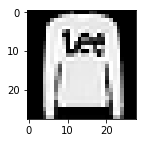

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(2, 2))
plt.imshow(x_original[1], cmap='gray')
print(y[1])

Standardize the Numpy array

In [26]:
x_original = np.expand_dims(x_original, axis=3)
x_original = x_original.astype('float32') / 255
y = np_utils.to_categorical(y, 10)

Evaluate the model and calculated test accuracy

In [27]:
scores = model.evaluate(x_original, y, verbose=0)
print('model test loss:    ', scores[0]*100)
print('model test accuracy:', scores[1]*100)
model_accuracy = scores[1]*100

model test loss:     38.04996589422226
model test accuracy: 86.49


### 4.2. Craft Adversarial Samples <a id="craft_adv_samples"></a>

After loading & compiling the model, we can create a `KerasClassifier` from the ART library.

In [28]:
from art.classifiers.keras import KerasClassifier

classifier = KerasClassifier((0, 1), model)

ART exposes many attacks like FGM, NewtonFool, DeepFool, Carlini etc. Let's use the Fast Gradient Method (FGM) to craft adversarial samples based on the test data (`x_test`).

In [29]:
from art.attacks.fast_gradient import FastGradientMethod

# configuration
epsilon = 0.2

# create crafter object
crafter = FastGradientMethod(classifier, eps=epsilon)

# craft samples on x_test (stored in variable x_original)
x_adv_samples = crafter.generate(x_original)

# save the adversarial samples
adv_samples_filename = "adv_samples.npz"
np.savez(adv_samples_filename, x_original=x_original, x_adversarial=x_adv_samples, y=y)

print("Number of adversarial samples crafted:", len(x_adv_samples))
print("adversarial samples saved to:", adv_samples_filename)

Number of adversarial samples crafted: 10000
adversarial samples saved to: adv_samples.npz


### 4.3. Generate Model Robustness Metrics <a id="robustness_check"></a>

The following functions can be used for gathering metrics like model robustness, confidence metric, perturbation metric

In [30]:
import numpy.linalg as la
import json


def get_metrics(model, x_original, x_adv_samples, y):
    scores = model.evaluate(x_original, y, verbose=0)
    model_accuracy_on_non_adversarial_samples = scores[1] * 100

    y_pred = model.predict(x_original, verbose=0)
    y_pred_adv = model.predict(x_adv_samples, verbose=0)

    scores = model.evaluate(x_adv_samples, y, verbose=0)
    model_accuracy_on_adversarial_samples = scores[1] * 100

    pert_metric = get_perturbation_metric(x_original, x_adv_samples, y_pred, y_pred_adv, ord=2)
    conf_metric = get_confidence_metric(y_pred, y_pred_adv)

    data = {
        "model accuracy on test data:": model_accuracy_on_non_adversarial_samples,
        "model accuracy on adversarial samples": model_accuracy_on_adversarial_samples,
        "reduction in confidence": conf_metric * 100,
        "average perturbation": pert_metric * 100
    }
    return data


def get_perturbation_metric(x_original, x_adv, y_pred, y_pred_adv, ord=2):

    idxs = (np.argmax(y_pred_adv, axis=1) != np.argmax(y_pred, axis=1))

    if np.sum(idxs) == 0.0:
        return 0

    perts_norm = la.norm((x_adv - x_original).reshape(x_original.shape[0], -1), ord, axis=1)
    perts_norm = perts_norm[idxs]

    return np.mean(perts_norm / la.norm(x_original[idxs].reshape(np.sum(idxs), -1), ord, axis=1))


# This computes the change in confidence for all images in the test set
def get_confidence_metric(y_pred, y_pred_adv):

    y_classidx = np.argmax(y_pred, axis=1)
    y_classconf = y_pred[np.arange(y_pred.shape[0]), y_classidx]

    y_adv_classidx = np.argmax(y_pred_adv, axis=1)
    y_adv_classconf = y_pred_adv[np.arange(y_pred_adv.shape[0]), y_adv_classidx]

    idxs = (y_classidx == y_adv_classidx)

    if np.sum(idxs) == 0.0:
        return 0

    idxnonzero = y_classconf != 0
    idxs = idxs & idxnonzero

    return np.mean((y_classconf[idxs] - y_adv_classconf[idxs]) / y_classconf[idxs])

Display the robustness check metrics

1. Model accuracy on test data
2. Model robustness on adversarial samples
3. Reduction in confidence
4. Perturbation metric

In [31]:
result = get_metrics(model, x_original, x_adv_samples, y)

print(json.dumps(result, indent=4, sort_keys=False))

{
    "model accuracy on test data:": 86.49,
    "model accuracy on adversarial samples": 13.71,
    "reduction in confidence": 49.82583820819855,
    "average perturbation": 43.59939992427826
}


### 4.4. Show Model Predictions on Adversarial Samples <a id="show_adv_samples"></a>

In [32]:
# https://keras.io/datasets/#fashion-mnist-database-of-fashion-articles

fashion_labels = {
 0: "T-shirt/top",
 1: "Trouser",
 2: "Pullover",
 3: "Dress",
 4: "Coat",
 5: "Sandal",
 6: "Shirt",
 7: "Sneaker",
 8: "Bag",
 9: "Ankle boot"
}

def get_label(y):
    if "fashion" in dataset_filename:
        return fashion_labels[y]
    else:
        return "Predict: %i" % y

Compare original images in the top row with the adversarial samples in the second row and test model predictions

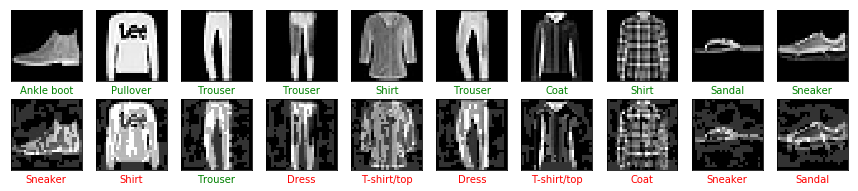

In [33]:
x_orig = ((x_original   ) * 255).astype('int')[:, :, :, 0]
x_adv  = ((x_adv_samples) * 255).astype('int')[:, :, :, 0]

y_pred_orig = model.predict(x_original,    verbose=0)
y_pred_adv  = model.predict(x_adv_samples, verbose=0)

fig    = plt.figure(figsize=(15, 3))
cols   = 10
rows   = 2
images = list(x_orig[:cols])      + list(x_adv[:cols])
preds  = list(y_pred_orig[:cols]) + list(y_pred_adv[:cols])
labels = list(y[:cols])           + list(y[:cols])

for i in range(0, len(images)):
    ax = fig.add_subplot(rows, cols, i+1)
    y_pred = np.argmax(preds[i])
    y_orig = np.argmax(labels[i])
    ax.set_xlabel(get_label(y_pred),
                  color = "green" if y_pred == y_orig else "red")
    ax.tick_params(axis='both', which='both',
                   bottom=False, top=False,
                   right=False, left=False,
                   labelbottom=False, labelleft=False)
    plt.imshow(images[i], cmap='gray')

plt.show()

## 5. Summary and Next Steps <a id="summary"></a>

This notebook only looked at one adversarial robustness technique (FGM). The *ART* library contains many more attacks, metrics and defenses to help you understand and improve your model's robustness. You can use this notebook as a template to experiment with all aspects of *ART*. Find more state-of-the-art methods for attacking and defending classifiers here:

https://github.com/IBM/adversarial-robustness-toolbox

## Acknowledgements

Special thanks to [Anupama-Murthi](https://github.ibm.com/Anupama-Murthi) and [Vijay Arya](https://github.ibm.com/vijay-arya) who created the original notebook which we modified here to showcase how to use *ART* with *FfDL*. If you would like to try *[Watson Machine Learning (WML) Service](https://console.bluemix.net/catalog/services/machine-learning)* with *ART* check out Anupama and Vijay's notebook here:

[https://github.ibm.com/robust-dlaas/ART-in-WML/Use ART to check robustness of deep learning models.ipynb](https://github.ibm.com/robust-dlaas/ART-in-WML/blob/master/Use%20ART%20to%20check%20robustness%20of%20deep%20learning%20models.ipynb)

Copyright © 2018 IBM. This notebook and its source code are released under the terms of the MIT License.